<a href="https://colab.research.google.com/github/KimJongkwang/Study-R/blob/main/get_data_by_api_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
package_version(R.version)

[1] ‘4.2.1’

In [2]:
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.1                         
year           2022                        
month          06                          
day            23                          
svn rev        82513                       
language       R                           
version.string R version 4.2.1 (2022-06-23)
nickname       Funny-Looking Kid           

In [3]:
library(dplyr)
library(httr)  # GET()
library(xml2)  # as_list()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 데이터 수집하기(API)

In [4]:
URL <- "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
KEY <- ""

## API 요청하기(XML)

In [5]:
query_list <- list(
    serviceKey = I(KEY),  # 인증키 %가 있으면 더블인코딩 문제 발생 그래서 I()
    numOfRows = "10",
    pageNo = "1",
    dataType = "XML",
    base_date = "20220917",
    base_time = "0500",
    nx = "60",
    ny = "127"
    )

response <- GET(url = URL, query = query_list)

### xml2 패키지 도움받기
#### 직접 속성에 접근

In [6]:
data_xml <- httr::content(response) %>% xml2::as_list()
items_xml <- data_xml$response$body$items

df <- data.frame()
for (i in seq(length(items_xml))){
    df <- rbind(df, unlist(items_xml[i]$item))
}
names(df) <- c('baseDate','baseTime','category','fcstDate','fcstTime','fcstValue','nx','ny')

#### 패키지 함수 사용

In [7]:
item_content <- xml2::xml_find_all(content(response), xpath = "//item")
unlist_data <- unlist(xml2::as_list(item_content), use.name = F)
matrix_data <- matrix(unlist_data, ncol = 8, byrow=T)
df <- data.frame(matrix_data)
names(df) <- c('baseDate','baseTime','category','fcstDate','fcstTime','fcstValue','nx','ny')

### XML 패키지 도움받기

In [8]:
install.packages("XML")
require("XML")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: XML



In [9]:
query_string <- paste0(
    "serviceKey=", query_list$serviceKey,
    "&numOfRows=", query_list$numOfRows,
    "&pageNo=", query_list$pageNo,
    "&dataType=", "XML",
    "&base_date=", query_list$base_date,
    "&base_time=", query_list$base_time,
    "&nx=", query_list$nx,
    "&ny=", query_list$ny
    )

request_url <- paste0(URL, "?", query_string)

In [10]:
response <- xmlTreeParse(request_url, useInternalNodes = T, encoding = "UTF-8")
xml_root <- xmlRoot(response)
xml_item_node <- getNodeSet(doc = xml_root, path = "//response/body/items/item")
df <- xmlToDataFrame(xml_item_node)

In [11]:
head(df, 2)

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,20220917,0500,TMP,20220917,0600,24,60,127
2,20220917,0500,UUU,20220917,0600,-0.5,60,127


## API 요청하기(JSON)

In [18]:
query_string <- paste0(
    "serviceKey=", query_list$serviceKey,
    "&numOfRows=", query_list$numOfRows,
    "&pageNo=", query_list$pageNo,
    "&dataType=", "JSON",
    "&base_date=", query_list$base_date,
    "&base_time=", query_list$base_time,
    "&nx=", query_list$nx,
    "&ny=", query_list$ny
    )

request_url <- paste(URL, query_string, sep="?")
response <- GET(url=request_url)

데이터 확인

In [19]:
request_url

[1] "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst?serviceKey=3fFyL9wc7wsGOpUkhxQchp0AZBH8PlyNELGTdLSBGeXMNgaPRcHbWZ%2FsKlNnnw4q67omLLYJM34Yu1osH58d9w%3D%3D&numOfRows=10&pageNo=1&dataType=JSON&base_date=20220917&base_time=0500&nx=60&ny=127"

In [ ]:
content(response)

In [ ]:
help(content)

```
content                  package:httr                  R Documentation

     There are currently three ways to retrieve the contents of a
     request: as a raw object (‘as = "raw"’), as a character vector,
     (‘as = "text"’), and as parsed into an R object where possible,
     (‘as = "parsed"’). If ‘as’ is not specified, ‘content’ does its
     best to guess which output is most appropriate.
```

In [14]:
content(response)
# content(response)$response$body$items

{xml_document}
<OpenAPI_ServiceResponse>
[1] <cmmMsgHeader>\n  <errMsg>SERVICE ERROR</errMsg>\n  <returnAuthMsg>HTTP_E ...

In [ ]:
# content(response, as = "raw")
# content(response, as = "text")
# content(response, as = "parsed")

In [20]:
unlist_data <- unlist(content(response)$response$body$items, use.name = F)
matrix_data <- matrix(unlist_data, ncol = 8, byrow=T)
df <- data.frame(matrix_data)
names(df) <- c('baseDate','baseTime','category','fcstDate','fcstTime','fcstValue','nx','ny')

In [21]:
head(df, 2)

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,20220917,0500,TMP,20220917,0600,24,60,127
2,20220917,0500,UUU,20220917,0600,-0.5,60,127


## jsonlite 패키지

`content()`함수가 list로 변환시키지 못하고 json으로 받았을 경우

In [22]:
library(jsonlite)

In [23]:
# list data 역으로 json으로 변환
json_content <- jsonlite::toJSON(content(response), pretty = T, auto_unbox = T)
# json_content

In [24]:
from_json_content <- jsonlite::fromJSON(json_content)
# from_json_content

In [25]:
# item 속성 접근하여 df 할당
df <- from_json_content$response$body$items$item
# df


# 데이터 수집부터 간단한 시각화하기

## 문제정의

기상청의 단기 예보와 관측데이터를 비교해보자.(서울에 국한하여)


최근 2일간 기상청 단기예보 API와 관측강수 API를 받아 1시간 단위로 비교해보고 시각화(강수량과 기온)
- 단기예보 API : https://www.data.go.kr/data/15084084/openapi.do
- 관측 API : https://www.data.go.kr/data/15057210/openapi.do

---

### 비교 항목 정보

- 단기예보의 nx, ny는 각각 60, 127(서울특별시 종로구 교남동)
    - base_date마다 base_time = "02"
    - 강수량 : PCP
    - 기온 : TMP
- 기상 관측소 108
    - 강수량 : rn
    - 기온 : ta
---



## 시간 설정

In [ ]:
help(Sys.timezone)

In [26]:
Sys.time()
Sys.time() + (3600 * 9)  # KST

[1] "2022-09-18 05:36:28 UTC"

[1] "2022-09-18 14:36:28 UTC"

In [27]:
now <- Sys.time() + (3600 * 9)  # KST
date <- format(now, "%Y%m%d")
time <- format(now, "%H00")
compare_time <- format(now - (3600 * 2), "%Y%m%d%H")  # "%Y%m%d%H -> YYYYMMDDHH"

In [28]:
library(dplyr)
library(tidyr)
library(httr)  # GET()
library(ggplot2)
library(stringr)

In [29]:
URL_FCST <- "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
URL_OBS <- "http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList"

### API를 통해 데이터프레임 반환 함수

In [30]:
get_api <- function(url, cols){
    response <- GET(url=url) %>% content()
    print(response)
    unlist_data <- unlist(response$response$body$items, use.name = F)
    matrix_data <- matrix(unlist_data, ncol = 8, byrow=T)
    df <- data.frame(matrix_data)
    names(df) <- cols
    return(df)
}

In [31]:
date <- format(now - 3600, "%Y%m%d")

In [ ]:
fcst_query_string <- paste0(
    "serviceKey=", I(KEY),
    "&numOfRows=", "288",  # 12개 category * 24시간 : 0200자료를 사용하면 0300부터 예측 24시간을 넣어야 다음날 02시까지 자료나옴
    "&pageNo=", "1",  # pageNo 1 
    "&dataType=", "JSON",
    "&base_date=", date,
    "&base_time=", "0200",
    "&nx=", "60",
    "&ny=", "127"
    )

# 단기 예보
request_url <- paste(URL_FCST, fcst_query_string, sep="?")
fcst_cols <- c('baseDate','baseTime','category','fcstDate','fcstTime','fcstValue','nx','ny')
df <- get_api(request_url, fcst_cols)

In [33]:
head(df, 2)

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,20220918,0200,TMP,20220918,0300,24,60,127
2,20220918,0200,UUU,20220918,0300,-0.1,60,127


## 동네예보 2일간 데이터 병합

In [34]:
now <- Sys.time() + (3600 * 9)  # KST
date_1 <- format(now - (3600 * 24), "%Y%m%d")
date_2 <- format(now - (3600 * 48), "%Y%m%d")
dates <- c(date_2, date_1)

In [ ]:
fcst_cols <- c('baseDate','baseTime','category','fcstDate','fcstTime','fcstValue','nx','ny')
fcst_df <- data.frame(matrix(ncol = 8, nrow = 0))
colnames(fcst_df) <- fcst_cols

for (date in dates){
    fcst_query_string <- paste0(
        "serviceKey=", I(KEY),
        "&numOfRows=", "288",
        "&pageNo=", "1",
        "&dataType=", "JSON",
        "&base_date=", date,
        "&base_time=", "0200",
        "&nx=", "60",
        "&ny=", "127"
    )
    request_fcst_url <- paste(URL_FCST, fcst_query_string, sep="?")
    fcst_df <- rbind(fcst_df, get_api(request_fcst_url, fcst_cols))
}

### 기상관측 2일 데이터 수집

In [37]:
obs_query_string <- paste0(
        "serviceKey=", I(KEY),
        "&numOfRows=", "100",
        "&pageNo=", "1",
        "&dataType=", "JSON",
        "&dataCd=", "ASOS",
        "&dateCd=", "HR",  # 시간자료
        "&startDt=", date_2,
        "&startHh=", "03",
        "&endDt=", date_1,
        "&endHh=", "23",
        "&stnIds=", "108"
    )



request_obs_url <- paste(URL_OBS, obs_query_string, sep="?")
response <- GET(url=request_obs_url)
obs_df <- fromJSON(toJSON(content(response)))$response$body$items$item

### 예측, 관측 데이터 전처리

In [38]:
# pre_fcst_df <- fcst_df %>%

pre_fcst_df <- fcst_df %>% 
    filter(category == "TMP" | category == "PCP") %>% 
    mutate(tm = strptime(paste0(fcstDate, fcstTime), "%Y%m%d%H00")) %>%
    select(tm, category, fcstValue)

pre_fcst_df$tm <- format(pre_fcst_df$tm, "%Y%m%d%H")
pre_fcst_df <- pivot_wider(pre_fcst_df, id_cols = tm, names_from = category, values_from = fcstValue) %>% 
                rename(TMP_FCST="TMP", PCP_FCST="PCP")

In [39]:
pre_obs_df <- obs_df %>% 
    mutate(tm = format(strptime(tm, "%Y-%m-%d %H:00"), "%Y%m%d%H")) %>%
    select(tm, ta, rn) %>%
    rename(TMP_OBS="ta", PCP_OBS="rn")

In [40]:
df <- merge(pre_fcst_df, pre_obs_df, by = "tm", type = "inner") %>%
        select(tm, TMP_FCST, TMP_OBS, PCP_FCST, PCP_OBS) %>%
        mutate_all(funs(str_replace(., "강수없음", "0")))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [41]:
df$TMP_FCST <- as.numeric(df$TMP_FCST)
df$TMP_OBS <- as.numeric(df$TMP_OBS)
df$PCP_FCST <- as.numeric(df$PCP_FCST)
df$PCP_OBS <- as.numeric(df$PCP_OBS)
df[is.na(df)] <- 0

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [ ]:
help(str_replace)

In [42]:
summary(df)

      tm               TMP_FCST        TMP_OBS         PCP_FCST    PCP_OBS    
 Length:45          Min.   :22.00   Min.   :23.30   Min.   :0   Min.   :0.00  
 Class :character   1st Qu.:24.00   1st Qu.:23.70   1st Qu.:0   1st Qu.:0.00  
 Mode  :character   Median :25.00   Median :25.50   Median :0   Median :0.00  
                    Mean   :25.38   Mean   :25.75   Mean   :0   Mean   :0.42  
                    3rd Qu.:27.00   3rd Qu.:27.30   3rd Qu.:0   3rd Qu.:0.00  
                    Max.   :28.00   Max.   :29.40   Max.   :0   Max.   :8.00  

### 관측 기온 비교

In [43]:
df_chart <- pivot_longer(df, cols = -tm, names_to = "category", values_to = "value")
df_chart_tmp <- df_chart %>% filter(grepl("TMP", category))

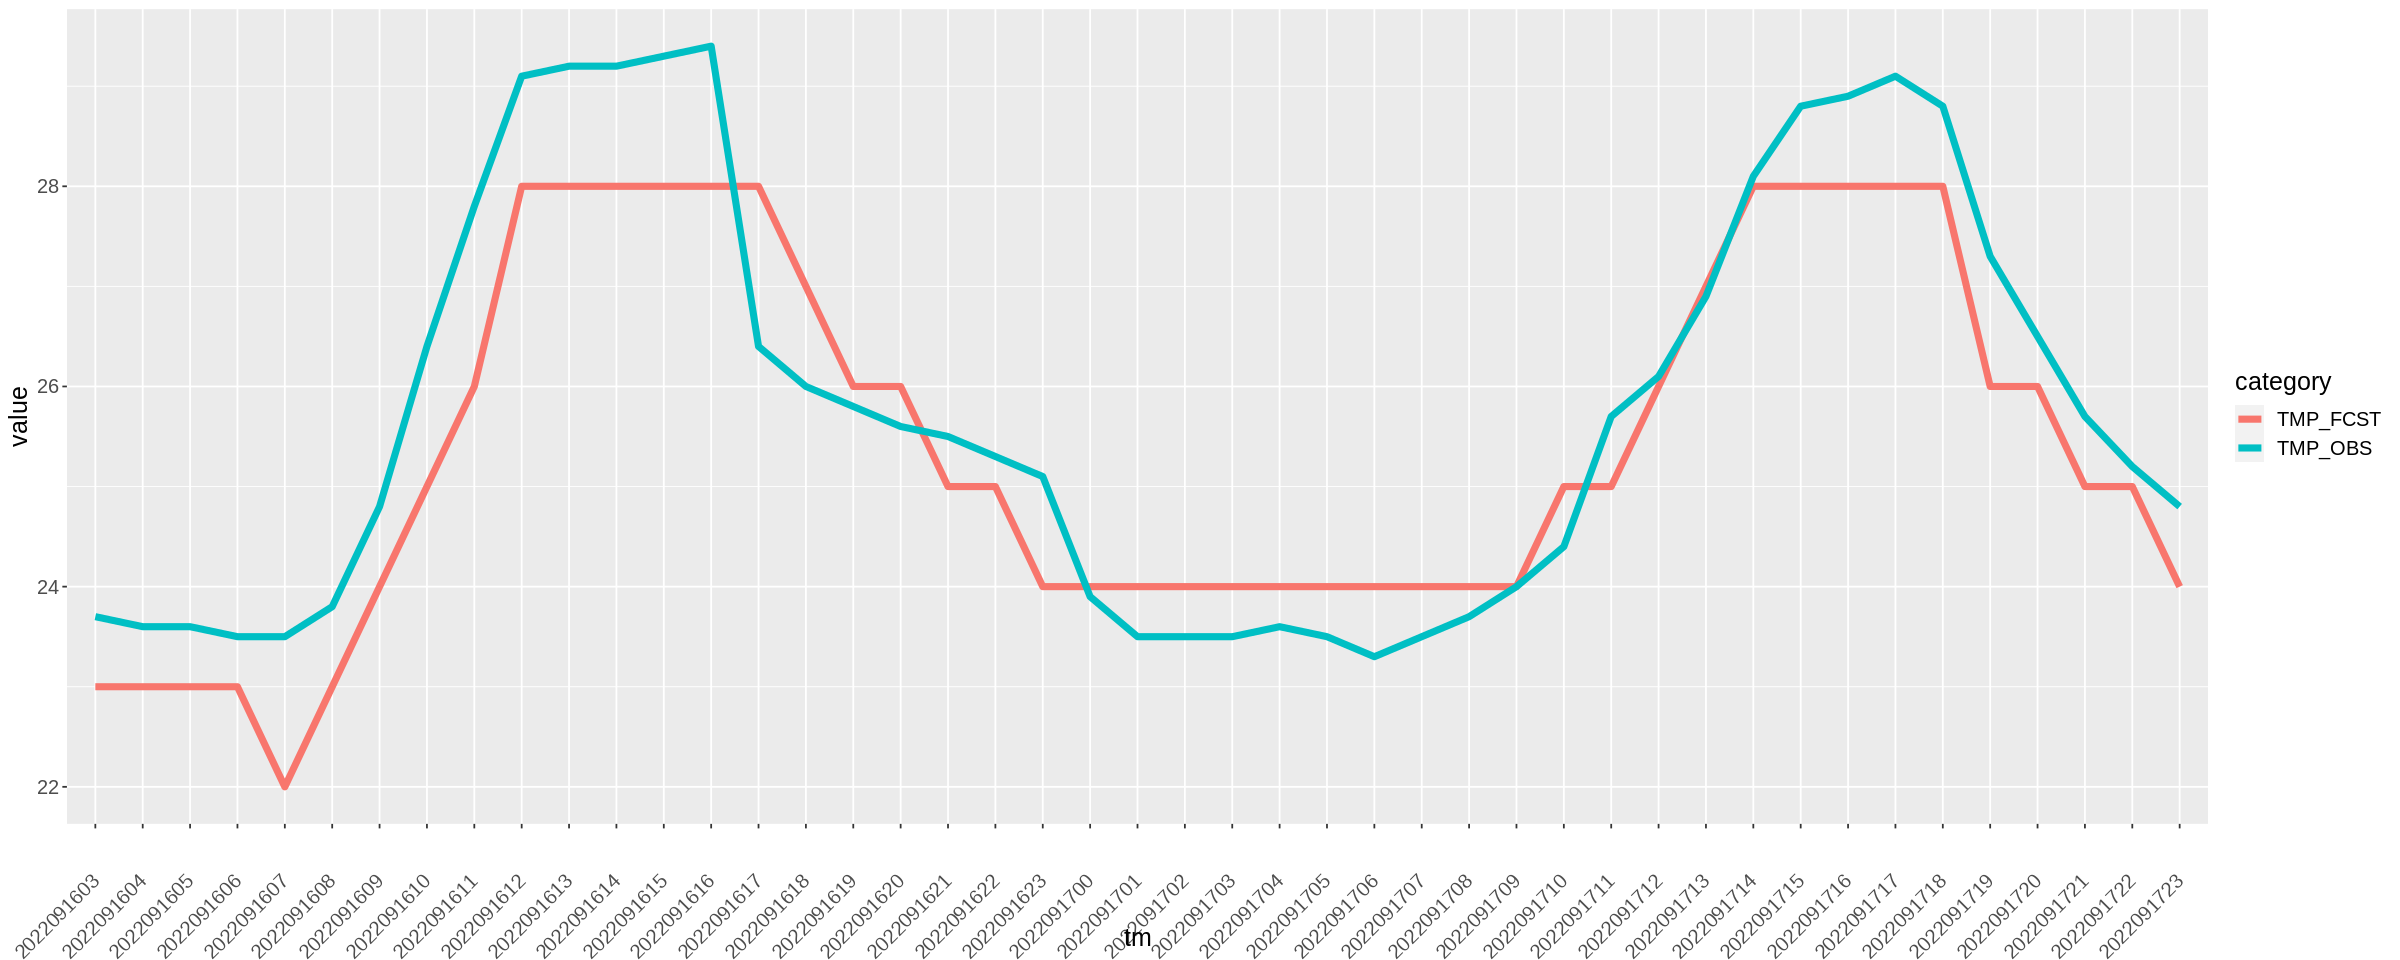

In [44]:
colorchip <- c("#d1495b", "#edae49", "#66a182")

options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data = df_chart_tmp, aes(x = tm, y = value, group = category, color = category)) + 
            geom_line(size=2) +
            theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1))

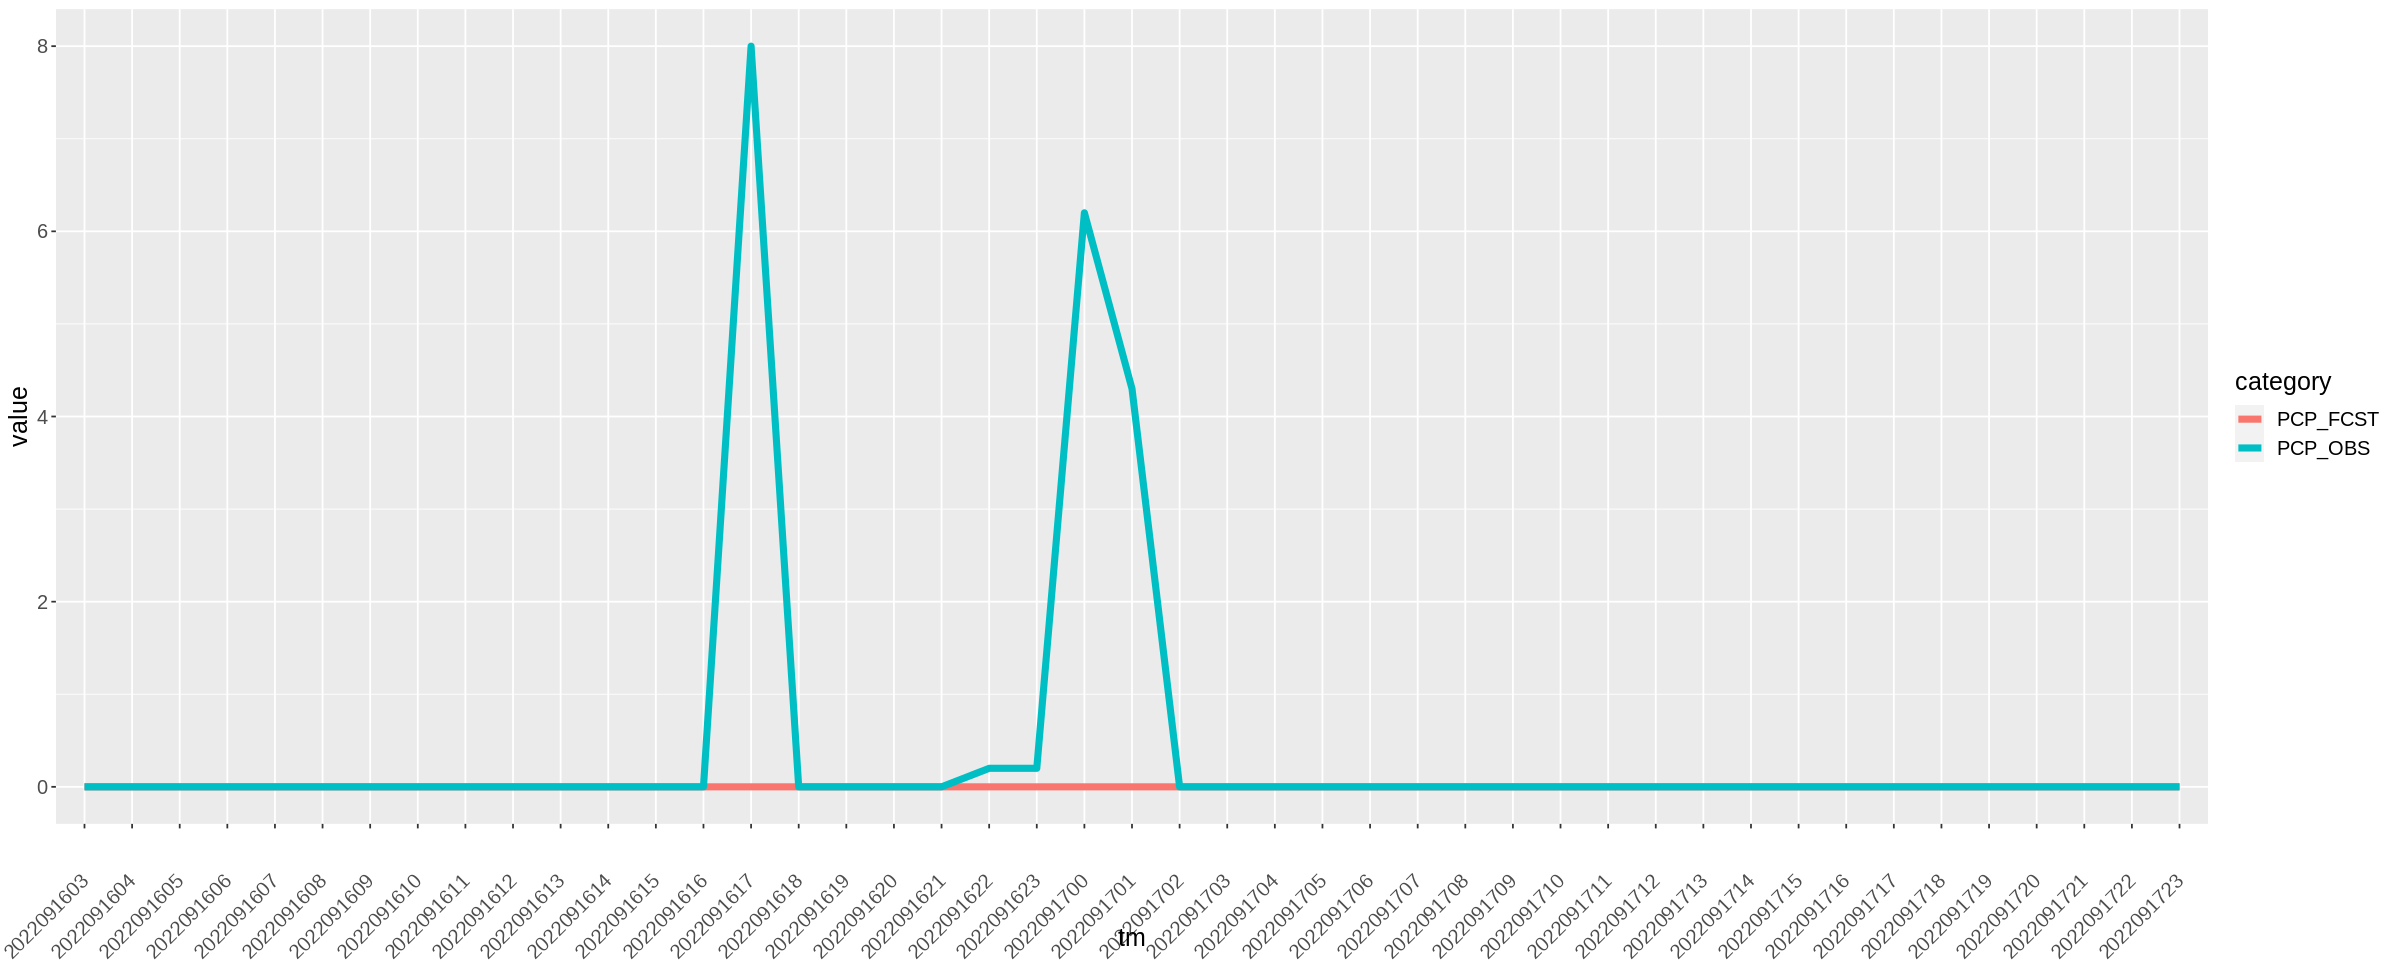

In [45]:
df_chart <- pivot_longer(df, cols = -tm, names_to = "category", values_to = "value")
df_chart_pcp <- df_chart %>% filter(grepl("PCP", category))

options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data = df_chart_pcp, aes(x = tm, y = value, group = category, color = category)) + 
            geom_line(size=2) +
            theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1))